# Bivariate Choropleth
This notebook will outline the procedure to construct a bivarate choropleth map in Python, using NYC PLUTO data.

In [159]:
# import necessary packages
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from collections import defaultdict
from census import Census

# import api key
import config
# set API key
CENSUS_API = config.CENSUS_API
c = Census(CENSUS_API, year=2019)

# surpress warnings
import warnings
warnings.filterwarnings('ignore')

## Load data

First we need to download the data, and next the shapefile.

### Download data

In [119]:
# variables
variables=('NAME',"B03002_001E","B03002_003E","B03002_004E","B03002_012E","B03002_006E","B17001_002E")

# download census data
ny_tract=c.acs5.state_county_tract(fields=variables,
                           state_fips=36,
                           county_fips="*",
                           tract="*")

In [120]:
# convert to df 
df_ny_tract=pd.DataFrame(ny_tract)
# create county fips list
nyc_county_fips = ["005","047","061","081","085"]
# filter for nyc
df=df_ny_tract[df_ny_tract["county"].isin(nyc_county_fips)]

In [121]:
def perc_rate(df, pop_col, other_col_list, new_col_list):
    """
    Takes in df, pop col, other col list, and new name  list
    drops original columns and renames pop column
    """
    # loop through other col list and name list
    for col, name in zip(other_col_list, new_col_list):
        df['temp'] = round(df[col] / df[pop_col] * 100,1)
        df[name] = df['temp']

    # rename pop col
    df['pop_count'] = df[pop_col]

    # drop the original columns for the population counts and keep only the new columns
    df.drop(columns=other_col_list + ['temp',pop_col], inplace=True)

In [122]:
col_list = ["B03002_003E","B03002_004E","B03002_012E","B03002_006E","B17001_002E"]
name_list = ['white_pct', 'black_pct', 'hispanic_pct', 'asian_pct', 'poverty_rate']

perc_rate(df, "B03002_001E", col_list, name_list)

In [123]:
df.head()

,NAME,state,county,tract,white_pct,black_pct,hispanic_pct,asian_pct,poverty_rate,pop_count
8,"Census Tract 361, Queens County, New York",36,081,036100,3.3,16.9,64.7,14.4,13.0,2238.0
9,"Census Tract 363, Queens County, New York",36,081,036300,3.7,14.9,72.8,6.5,20.3,1771.0
10,"Census Tract 371, Queens County, New York",36,081,037100,1.4,23.1,54.2,15.0,11.8,1335.0
11,"Census Tract 377, Queens County, New York",36,081,037700,0.5,5.3,90.1,4.2,12.1,3620.0
12,"Census Tract 379, Queens County, New York",36,081,037900,0.9,4.0,87.0,7.8,16.3,6851.0


Let's look at column info

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 8 to 4887
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   NAME          2167 non-null   object 
 1   state         2167 non-null   object 
 2   county        2167 non-null   object 
 3   tract         2167 non-null   object 
 4   white_pct     2124 non-null   float64
 5   black_pct     2124 non-null   float64
 6   hispanic_pct  2124 non-null   float64
 7   asian_pct     2124 non-null   float64
 8   poverty_rate  2124 non-null   float64
 9   pop_count     2167 non-null   float64
dtypes: float64(6), object(4)
memory usage: 186.2+ KB


### Download shapefile

Ok, now let's load in the shapefile from [NYC Open Data](https://data.cityofnewyork.us/City-Government/2010-Census-Tracts/fxpq-c8ku)

In [125]:
# load shpfile as gdf
gdf=gpd.read_file("https://data.cityofnewyork.us/api/geospatial/fxpq-c8ku?method=export&format=Shapefile")

# preview
gdf.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((-74.07921 40.64343, -74.07914 40.643..."
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.200308,"POLYGON ((-73.96433 40.75638, -73.96479 40.755..."
2,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((-73.97124 40.76094, -73.97170 40.760..."
3,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,"POLYGON ((-73.97446 40.76229, -73.97491 40.761..."
4,1,1011300,Manhattan,I,011300,113,MN17,Midtown-Midtown South,3807,1.890907e+06,5699.860640,"POLYGON ((-73.98412 40.75484, -73.98460 40.754..."


In [126]:
# get info
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2165 entries, 0 to 2164
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   boro_code   2165 non-null   object  
 1   boro_ct201  2165 non-null   object  
 2   boro_name   2165 non-null   object  
 3   cdeligibil  2164 non-null   object  
 4   ct2010      2165 non-null   object  
 5   ctlabel     2165 non-null   object  
 6   ntacode     2165 non-null   object  
 7   ntaname     2165 non-null   object  
 8   puma        2165 non-null   object  
 9   shape_area  2165 non-null   float64 
 10  shape_leng  2165 non-null   float64 
 11  geometry    2165 non-null   geometry
dtypes: float64(2), geometry(1), object(9)
memory usage: 203.1+ KB


In [127]:
# change crs
gdf.to_crs(2263, inplace=True)

Ok, it looks like we can join on `boro_ct2010` from **gdf**, but will have to create the `boro_code` column in **df** in order to make this possible. So let's create a feature that maps the correct boro code in **df** then concatenate it with `tract` column to match `boro_ct2010`.

- Manhattan = 1 = 061
- Bronx = 2 = 005
- Brooklyn = 3 = 047
- Queens = 4 = 081
- Staten Island = 5 = 085

In [128]:
# set variables
col = 'county'
conditions = [df[col] == "061",df[col] == "005",df[col] == "047",df[col] == "081",df[col] == "085"]
choices = ['1','2','3','4','5']

# compute conditional
df['boro_code'] = np.select(conditions, choices)

# concatenate boro_code and tract
df['boro_ct2010'] = df['boro_code'] + df['tract']

In [129]:
df.head()

,NAME,state,county,tract,white_pct,black_pct,hispanic_pct,asian_pct,poverty_rate,pop_count,boro_code,boro_ct2010
8,"Census Tract 361, Queens County, New York",36,081,036100,3.3,16.9,64.7,14.4,13.0,2238.0,4,4036100
9,"Census Tract 363, Queens County, New York",36,081,036300,3.7,14.9,72.8,6.5,20.3,1771.0,4,4036300
10,"Census Tract 371, Queens County, New York",36,081,037100,1.4,23.1,54.2,15.0,11.8,1335.0,4,4037100
11,"Census Tract 377, Queens County, New York",36,081,037700,0.5,5.3,90.1,4.2,12.1,3620.0,4,4037700
12,"Census Tract 379, Queens County, New York",36,081,037900,0.9,4.0,87.0,7.8,16.3,6851.0,4,4037900


Ok, now we can join

### Join

In [130]:
# join gdf with df
gdf_merged=pd.merge(gdf, df, left_on="boro_ct201", right_on="boro_ct2010")

Now that I have the data and shapefile, next step is to create basic choropleth map for each variable.

### Choropleth Map

First we need to create a dictionary with the **column name** as key, and **label** and **cmap** as value in a list. This will allow me to iterate through each column and apply both the label and cmap to each map.

In [131]:
# cols and labels dict
col_label_dict = {'poverty_rate':'Poverty Rate per Census Tract',
                'white_pct':'White population percentage per Census Tract',
                'black_pct':'Black population percentage per Census Tract',
                'hispanic_pct':'Latinx population percentage per Census Tract',
                'asian_pct':'Asian population percentage per Census Tract'}

# color map list
cmap_list = ["YlOrBr", "Blues", "BuGn", "BuPu", "OrRd"]


In [132]:

# create custom function
def create_dict_list_value(custom_dict, custom_list):
    """
    Takes dictionary with column names as key, and label as value
    Takes list with cmap
    Creates list as value for dict and append cmap as second item
    """
    col_label_cmap_dict = defaultdict(list) # create empty dict with list as value
    i=0
    for col, label in custom_dict.items():
        col_label_cmap_dict[col].append(label)
        col_label_cmap_dict[col].append(custom_list[i])
        i+=1
    return col_label_cmap_dict

In [133]:
# apply function
col_label_cmap_dict=create_dict_list_value(col_label_dict, cmap_list)

Loop through each aspect of `col_label_cmap_dict` and create choropleth for respective grouping.

In [208]:
def plot_column_from_dict(gdf, col_label_cmap_dict, alpha=0.85, font_size=14, save=False):
    """
    Take in gdf and column, label, colormap dict, plot map.
    Save boolean
    """
    # loop through and plot each key in dict
    for col, label_cmap in col_label_cmap_dict.items():
        # set figsize
        fig, ax = plt.subplots(1,1, figsize=(9,6))

        #plot with legend
        gdf.plot(col,
                colormap=label_cmap[1],
                vmin=0,
                ax=ax, 
                alpha=alpha, 
                legend=True,
                legend_kwds={'alpha':alpha,'shrink':0.7, 'pad':0.05})
        
        # set title
        ax.set_title(label_cmap[0], fontdict={'size':font_size})

        # turn off axis
        ax.axis('off')

        # add basemap
        ctx.add_basemap(ax=ax,
                        crs=gdf.crs,
                        source=ctx.providers.Stamen.TonerLite)
        
        if save:
            # save plots
            plt.savefig(f'images/{col}.png', dpi=300, bbox_inches='tight')
        else:
            pass

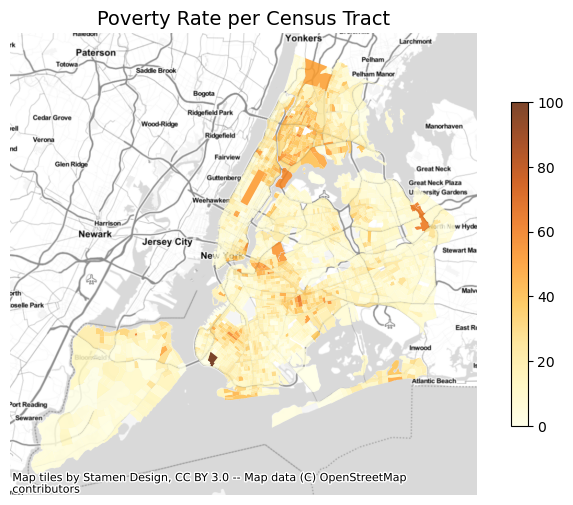

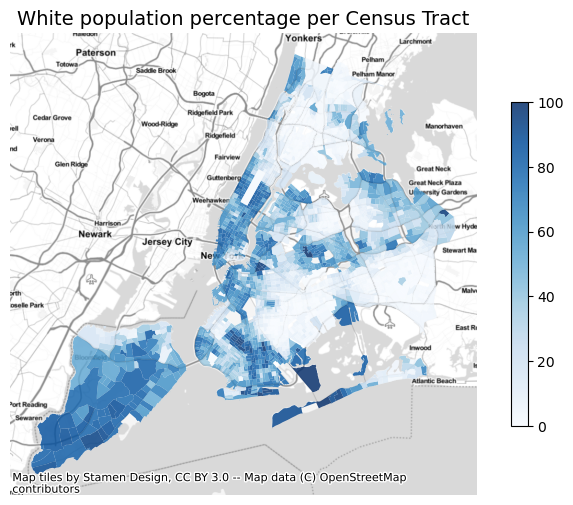

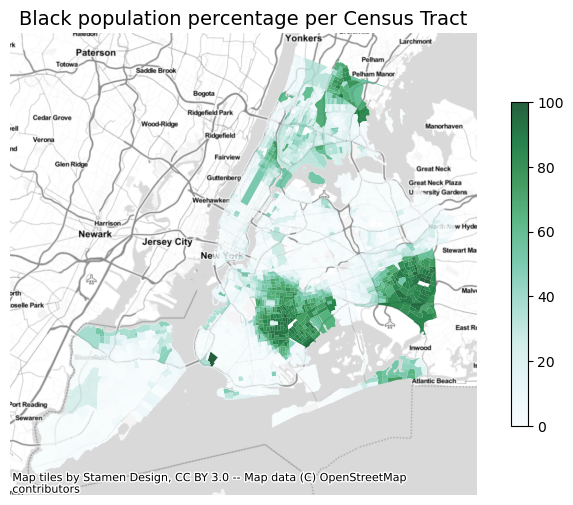

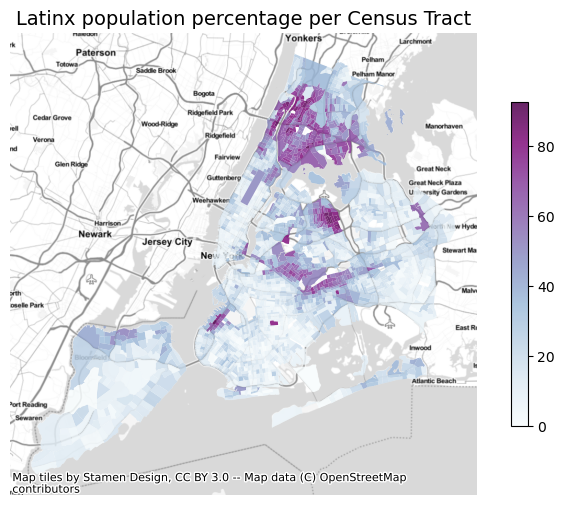

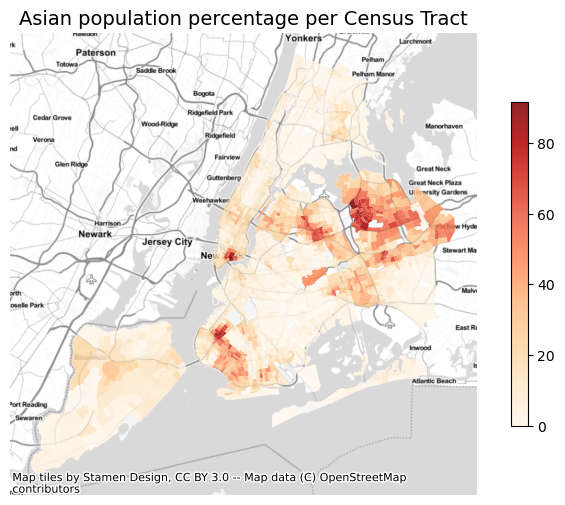

In [209]:
plot_column_from_dict(gdf_merged,col_label_cmap_dict)

Ok, this is great and all, but what if I want to compare poverty rate per race on one map, and I don't want to do this with graduated symbology.

### Bivariate Choropleth Map
Colormaps from Josha Stevens [Bivariate Choropleth Maps: a How-to Guide](https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/)<br>
![](images/cmap.png)

OK, so if I want to compare poverty rate and per race on one map, I have to break each variable down into 3 classes each, then overlay (rotate one 90 degrees prior to overlaying) and create a third attribute that represents a combination of the two variables from its location in the bivariate color scheme.<br>
Mark cells in horizontal order with A,B,C and mark cells in vertical order 1,2,3.

In [135]:
# basic matrix layout
jstevens_mat=np.array([[['A3','B3','C3'],
                        ['A2','B2','C2'],
                        ['A1','B1','C1']]])
# first col
jstevens_col_mats = [
    np.array([[['#64acbe','#627f8c','#574249'],
                ['#b0d5df','#ad9ea5','#985356'],
                ['#e8e8e8','#e4acac','#c85a5a']]]),
    np.array([[['#be64ac','#8c62aa','#3b4994'],
                ['#dfb0d6','#a5add3','#5698b9'],
                ['#e8e8e8','#ace4e4','#5ac8c8']]]),
    np.array([[['#73ae80','#5a9178','#2a5a5b'],
                ['#b8d6be','#90b2b3','#567994'],
                ['#e8e8e8','#b5c0da','#6c83b5']]]),
    np.array([[['#9972af','#976b82','#804d36'],
                ['#cbb8d7','#c8ada0','#af8e53'],
                ['#e8e8e8','#e4d9ac','#c8b35a']]])
]

Change number of classes to 3 and record break points.

In [136]:
# function to assign classes based on col
def equal_count_classes(df, columns):
    """
    Takes df and column list
    Creates new columns in equal 3 parts 
    with labels 1,2,3 if its poverty_rate, otherwise A,B,C
    """
    for col in columns:
        if col == 'poverty_rate':
            # divide the data into three classes based on equal count
            df[f'{col}_class'] = pd.qcut(df[col], q=3, labels=['1', '2', '3']).astype('str')
        else:
            df[f'{col}_class'] = pd.qcut(df[col], q=3, labels=['A', 'B', 'C']).astype('str')

In [137]:
# apply function to df
equal_count_classes(gdf_merged,list(col_label_cmap_dict.keys()))

Create a combination column for each **race perc** and `poverty_rate`.

In [138]:
# custom function
def bivariate_class_col(df, col_list, second_col='poverty_rate_class'):
    """
    Takes df and column list
    Concatenates first col and each col in col list creating new columns in df
    """
    # loop through col list and concatenate
    for col in col_list:
        new_col_name = col.split('_')[0] # create new col name up until _
        df[f'bi_{new_col_name}_class'] = df[col] + df[second_col]
    

In [139]:
# create list of race class columns
race_class = ['white_pct_class','black_pct_class', 'hispanic_pct_class', 'asian_pct_class']

# apply function
bivariate_class_col(gdf_merged, race_class)

Now we need to create a function to map values to colors based on the color matrix.

In [148]:
# helper function for create_color_col
def map_colors(value, col_matrix):
    # find the corresponding color for the value in the color matrix
    indices = np.where(jstevens_mat == value)
    
    if len(indices[0]) > 0:
        color = col_matrix[indices]
        return color[0]

    return None

In [149]:
# function to create color column per race and poverty rate
def create_color_col(df, columns, matrices):
    """
    Takes in df, column list, and list of color matrices
    Create color column
    """
    for col, col_matrix in zip(columns, matrices):
        new_col_name = col.split('_')[1] + '_color'
        df[new_col_name] = df[col].apply(map_colors, args=(col_matrix,))


In [150]:
# create col list
bi_race_class = ['bi_white_class', 'bi_black_class', 'bi_hispanic_class','bi_asian_class']

# Map the colors to the GeoDataFrame based on the 'Value' column
create_color_col(gdf_merged, bi_race_class, jstevens_col_mats)

Create dictionary for columns, labels and facecolor columns

In [211]:
# cols and labels dict
col_label_dict2 = {'white_pct':'White population percentage per Census Tract and Poverty Rate',
                'black_pct':'Black population percentage per Census Tract and Poverty Rate',
                'hispanic_pct':'Latinx population percentage per Census Tract and Poverty Rate',
                'asian_pct':'Asian population percentage per Census Tract and Poverty Rate'}

# facecolor column list
facecolor_list = ['white_color', 'black_color', 'hispanic_color','asian_color']

In [212]:
# apply function
col_label_cmap_dict2=create_dict_list_value(col_label_dict2, facecolor_list)

In [228]:
def plot_column_from_dict_facecolor(gdf, col_label_cmap_dict, alpha=0.85, font_size=14, 
                                    save=False):
    for col, label_cmap in col_label_cmap_dict.items():
        # Set figsize
        fig, ax = plt.subplots(1, 1, figsize=(9, 6))

        # Plot with legend
        gdf.plot(facecolor=gdf[label_cmap[1]].apply(lambda x: mcolors.to_rgba(x) \
                                                if isinstance(x, str) else (1, 1, 1)),
                 ax=ax,
                 alpha=alpha)

        # Set title
        ax.set_title(label_cmap[0], fontdict={'size': font_size})

        # Turn off axis
        ax.axis('off')

        # Add basemap
        ctx.add_basemap(ax=ax,
                        crs=gdf.crs,
                        source=ctx.providers.Stamen.TonerLite)
        if save:
            # Save plots
            plt.savefig(f'images/{col}.png', dpi=300, bbox_inches='tight')
        else:
            pass

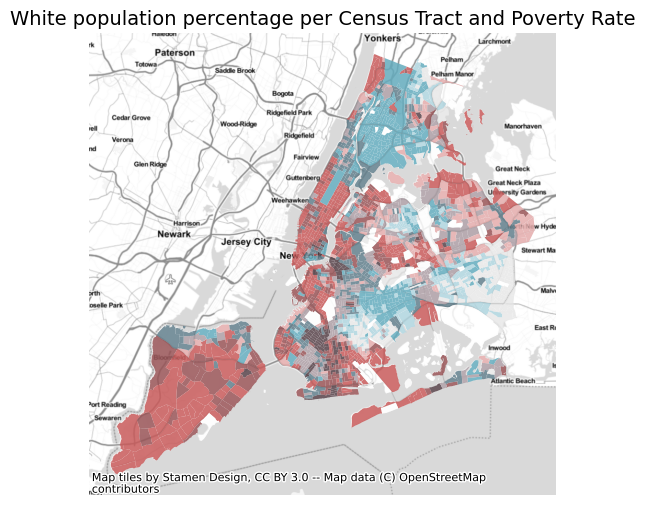

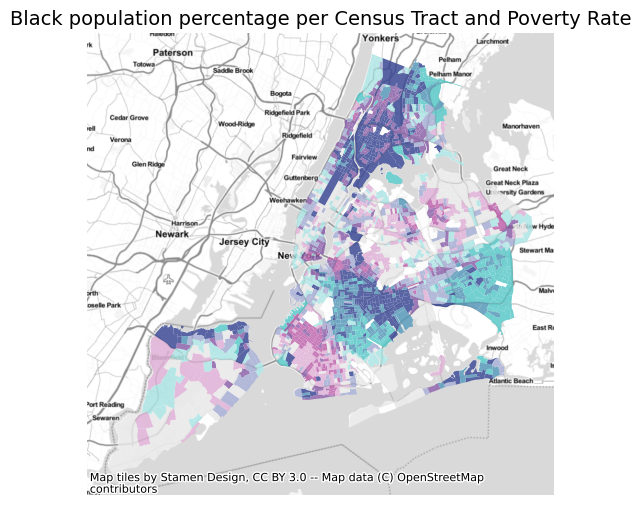

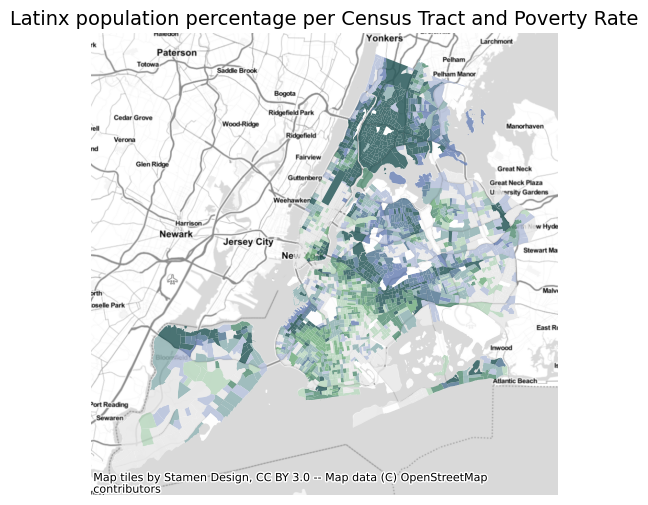

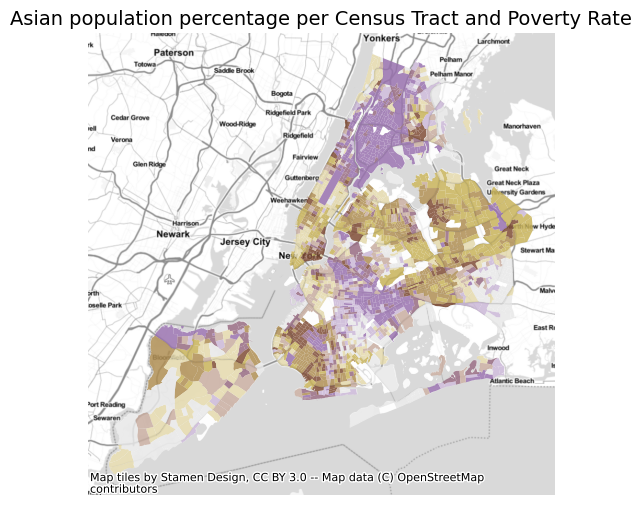

In [229]:
plot_column_from_dict_facecolor(gdf_merged, col_label_cmap_dict2)